# Figure 2

Still a draft. In process of testing ...

In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.path as mpath
import xarray as xr
import numpy as np
import datetime as dt
import cmocean as cm
import cartopy.crs as ccrs
import cartopy.feature as cft
from scipy import stats
from dask.distributed import Client

In [ ]:
client = Client(n_workers=8)
client

In [ ]:
HardDisk = '/g/data/v45/amh157/OCCIPUT/'
EnsembleDir = 'processed_eke/'

In [ ]:
land_50m = cft.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='black',
                                        facecolor='gray',
                                        linewidth=1.0)

In [8]:
def pearsoncor(y1, y2):
    ## Looking for lagged correlations between two timeseries
    ## Assumes y1 is leading
    ## Avoid end effects by using only first 2/3rds of timeseries
    ## Calculates effective sample size using lag1-autocorrelations (Kial Stewart)
    ## Also, finds sampe size by a second method thanks to Josue
    
    n = len(y1)
    nc = int(n/3.5)
    
    # De-mean both timeseries
    y1t = y1-np.mean(y1)
    y2t = y2-np.mean(y2)    

    cor = np.zeros(nc)
    sig = np.zeros(nc)
    Neff = np.zeros(nc)
    for j in np.arange(0, nc):
        x1t = np.roll(y1t, j)[j:]#y1t[:-j]
        x2t = y2t[j:]
        
        # Compute Neff for each sample using the Kial Stewart/Darryn Waugh method:
        r1, tmp = stats.pearsonr(x1t[1:], np.roll(x1t, 1)[1:])
        r2, tmp = stats.pearsonr(x2t[1:], np.roll(x2t, 1)[1:])
        Neff[j] = n*(1-r1*r2)/(1+r1*r2)
        
        cor[j], sig[j] = stats.pearsonr(x1t, x2t)
    
    #Josue's alternate Neff method
    idx = np.arange(1,nc)
    sni = np.sum((1 - idx/nc) * cor[idx])
    n_star = 1 + 2 * sni
    Neff2 = n/n_star

    return cor, sig, Neff, Neff2

## Other things to set

In [9]:
nfiles = 50
col = 'r'
start = dt.datetime(1980,1,1) ## start time for plotting
end = dt.datetime(2014,12,31)

# set latitude bounds - otherwise, use whole SO.
lat1 = -60
lat2 = -40

## Load wind stress first
Note, this is the same for all ensemble members.

In [10]:
taufilename = HardDisk+'processed_tau/'+'tau_????.nc'
tau = xr.open_mfdataset(taufilename).tau.sel(lat=slice(lat1,lat2)).mean('lon').mean('lat').load()

## Process EKE
This loads eke for each ensemble member

In [11]:
eke_results = []
nn=0
for ii in range(1,nfiles+1):
    nn+=1
    i00 = '%03d' % ii
    Member = 'e'+i00
    ekefilename = HardDisk+EnsembleDir+'/eke_'+i00+'_????.nc'
        
    eke = xr.open_mfdataset(ekefilename).EKE.sel(lat=slice(lat1,lat2)).mean('lon').mean('lat').load()
    result = {'ii': ii,'eke': eke}
    eke_results.append(result)
    
    if ii==1:
        eke_sum = eke
    else:
        eke_sum = eke_sum + eke
                        
eke_sum = eke_sum.load()/nn

## Compute variance ratios from saved results

THis variance estimate includes seasonal cycle, so probably isn't relevant ...

In [12]:
for result in eke_results:
    ii = result['ii']
    eke = result['eke']
    if ii==1:
        eke_var = (eke - eke_sum)**2
    else:
        eke_var = eke_var + (eke - eke_sum)**2
        
eke_var = eke_var.load()/nn
sigma2 = np.var(eke_sum)  
epsilon2 = eke_var.mean('time')
ratio = (epsilon2/(epsilon2+sigma2))
print('Southern Ocean -- fraction of intrinsic variance: R_i = %0.2f'%ratio.values)

Southern Ocean -- fraction of intrinsic variance: R_i = 0.69


# Option 0 - no filtering.
This is not a practical option as all interannual signals are destroyed by seasonality.

Correlations: 9 months, 0.66, 0.00
Effective sample size: 110 or 124
T-statistic at max correlation: 9.20 


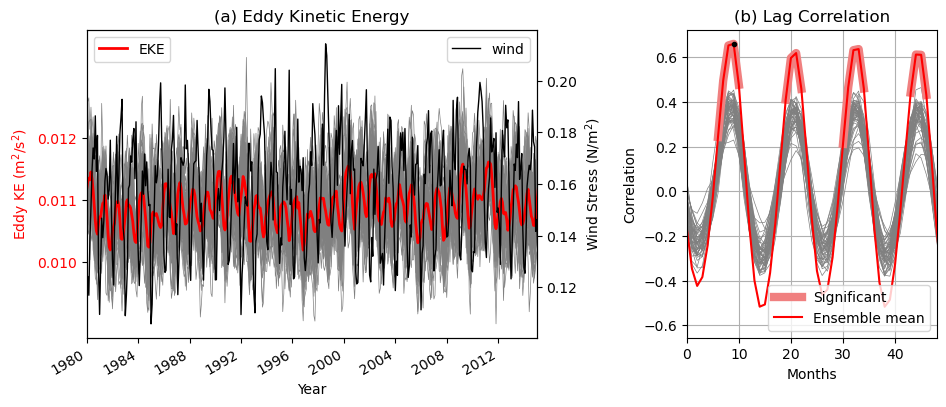

In [13]:
plt.figure(figsize=(10, 4))

## Axes to plot EKE timeseries
ax_eke = plt.axes([0.1,0.13,0.45,0.77])
## Axes to plot lagged correlation
ax_corr = plt.axes([0.7,0.13,0.25,0.77])

for result in eke_results:
    eke = result['eke']
    eke.plot(ax=ax_eke,color=[0.5, 0.5, 0.5],linewidth=0.5)
    
    coef, signif, Neff, Neff2 = pearsoncor(tau,eke)
    ax_corr.plot(coef,color=[0.5, 0.5, 0.5],linewidth=0.5)

# In this case I am filtering eke_sum -- rather than averaging and then filtering
eke_sum.plot(ax=ax_eke,color=col,linewidth=2,label='EKE')
ax_eke.set_xlabel('Year')
ax_eke.set_ylabel('Eddy KE (m$^2$/s$^2$)',color=col)
ax_eke.set_yticks([0.01, .011, .012])
ax_eke.tick_params('y',labelcolor=col)
ax_eke.set_xlim([start,end])
ax_eke.set_title('(a) Eddy Kinetic Energy')
ax_eke.legend(loc=2)


## Axes to plot the wind
ax_tau=ax_eke.twinx()

tau.plot(ax=ax_tau,color='k',linewidth=1,label='wind')
#ax_tau.set_ylim([0.135,0.185])
ax_tau.set_ylabel('Wind Stress (N/m$^2$)')
ax_tau.set_xlim([start,end])

ax_tau.legend(loc=1)

coef, signif, Neff, Neff2 = pearsoncor(tau,eke_sum)
lag = coef.argmax() 
print('Correlations: %d months, %0.2f, %0.2f'%(lag, coef[lag], signif[lag]))
print('Effective sample size: %d or %d'%(Neff[lag], Neff2))
T = coef[lag]*Neff[lag]**(0.5)*(1-coef[lag]**2)**(-0.5)
print('T-statistic at max correlation: %0.2f '% T)
Tstat = coef*Neff**(0.5)*(1-coef**2)**(-0.5)
coef_sig = np.where(Tstat>1.96,coef,np.NaN)
ax_corr.plot(coef_sig,linewidth=6,color='lightcoral',label='Significant')
ax_corr.plot(coef,linewidth=1.5,color='r',label='Ensemble mean')
ax_corr.plot(lag,coef[lag],'k.')

ax_corr.set_xlim([0,48])
#ax_corr.set_ylim([-0.3,0.6])
#ax_corr.set_xticks([0, 12, 24, 36])
ax_corr.set_title('(b) Lag Correlation')
ax_corr.set_xlabel('Months')
ax_corr.set_ylabel('Correlation')
ax_corr.grid()

ax_corr.legend()

# Option 1 - use rolling averages

This option eliminates seasonality, but the significance (as defined by Kial Stewart's method) tells us that nothing is significant.

Note that Josue's alternative method for calculating the effective sample size gives a number that is double Kial's and makes a few points statistically significant (this is the option I use to show results here).

Correlations: 7 months, 0.48, 0.00
Effective sample size: 11 or 27
T-statistic at max correlation: 1.59 


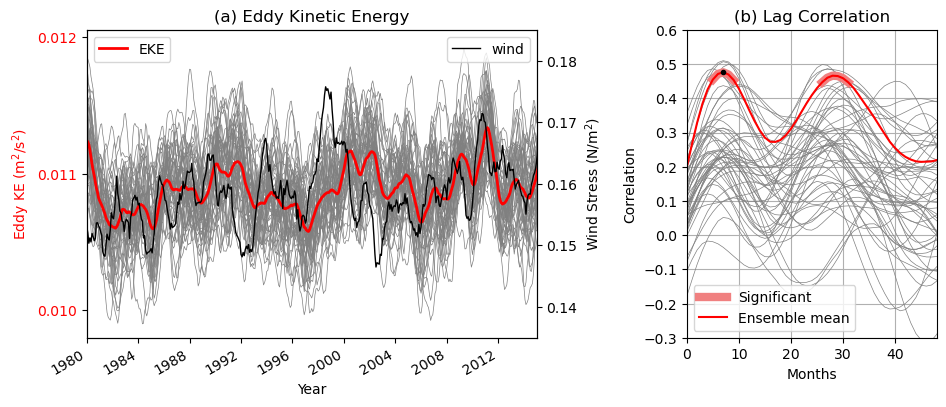

In [20]:
plt.figure(figsize=(10, 4))

## Axes to plot EKE timeseries
ax_eke = plt.axes([0.1,0.13,0.45,0.77])
## Axes to plot lagged correlation
ax_corr = plt.axes([0.7,0.13,0.25,0.77])

tau_rolling = tau.rolling(time=12,center=True).mean().isel(time=slice(6,-6))

for result in eke_results:
    eke_rolling = result['eke'].rolling(time=12,center=True).mean().isel(time=slice(6,-6))
    eke_rolling.plot(ax=ax_eke,color=[0.5, 0.5, 0.5],linewidth=0.5)
    
    coef, signif, Neff, Neff2 = pearsoncor(tau_rolling,eke_rolling)
    ax_corr.plot(coef,color=[0.5, 0.5, 0.5],linewidth=0.5)

# In this case I am filtering eke_sum -- rather than averaging and then filtering
eke_sum_rolling = eke_sum.rolling(time=12,center=True).mean().isel(time=slice(6,-6))
eke_sum_rolling.plot(ax=ax_eke,color=col,linewidth=2,label='EKE')
ax_eke.set_xlabel('Year')
ax_eke.set_ylabel('Eddy KE (m$^2$/s$^2$)',color=col)
ax_eke.set_yticks([0.01, .011, .012])
ax_eke.tick_params('y',labelcolor=col)
ax_eke.set_xlim([start,end])
ax_eke.set_title('(a) Eddy Kinetic Energy')
ax_eke.legend()


## Axes to plot the wind
ax_tau=ax_eke.twinx()

tau_rolling.plot(ax=ax_tau,color='k',linewidth=1,label='wind')
ax_tau.set_ylim([0.135,0.185])
ax_tau.set_ylabel('Wind Stress (N/m$^2$)')
ax_tau.set_xlim([start,end])

ax_tau.legend()

coef_sum, signif_sum, Neff_sum, Neff_sum2 = pearsoncor(tau_rolling,eke_sum_rolling)
lag = coef_sum.argmax() 
print('Correlations: %d months, %0.2f, %0.2f'%(lag, coef_sum[lag], signif[lag]))
print('Effective sample size: %d or %d'%(Neff[lag], Neff2))
T = coef_sum[lag]*Neff_sum[lag]**(0.5)*(1-coef_sum[lag]**2)**(-0.5)
print('T-statistic at max correlation: %0.2f '% T)
Tstat = coef_sum*Neff_sum2**(0.5)*(1-coef_sum**2)**(-0.5)
coef_sig = np.where(Tstat>1.96,coef_sum,np.NaN)
ax_corr.plot(coef_sig,linewidth=6,color='lightcoral',label='Significant')
ax_corr.plot(coef_sum,linewidth=1.5,color='r',label='Ensemble mean')
ax_corr.plot(lag,coef_sum[lag],'k.')

ax_corr.set_xlim([0,48])
ax_corr.set_ylim([-0.3,0.6])
#ax_corr.set_xticks([0, 12, 24, 36])
ax_corr.set_title('(b) Lag Correlation')
ax_corr.set_xlabel('Months')
ax_corr.set_ylabel('Correlation')
ax_corr.grid()

ax_corr.legend()


# Option 2 - annual averages

This eliminates the seasonal signal and gives significant correlations (according to Kial's method, but not according to Josue's method!). But it looks ugly!! And we only get annual lags.

Correlations: 1 months, 0.43, 0.01
Effective sample size: 37 or 16
T-statistic at max correlation: 2.70 


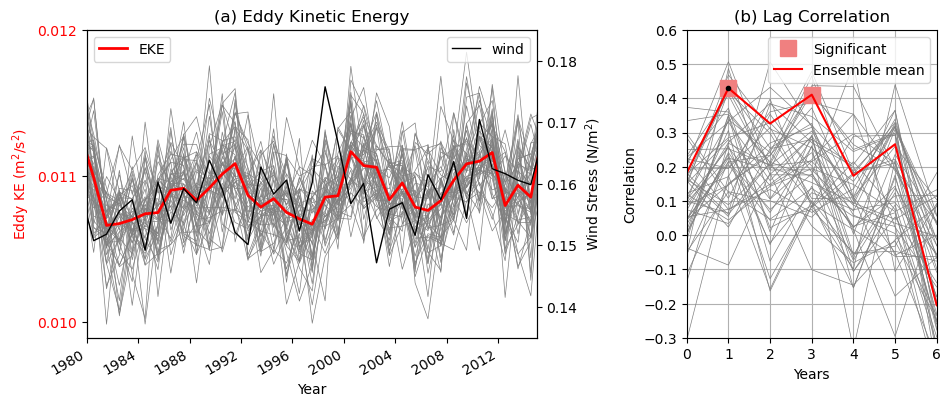

In [32]:
plt.figure(figsize=(10, 4))

## Axes to plot EKE timeseries
ax_eke = plt.axes([0.1,0.13,0.45,0.77])
## Axes to plot lagged correlation
ax_corr = plt.axes([0.7,0.13,0.25,0.77])

tau_annual = tau.coarsen({"time":12}).mean()

for result in eke_results:
    eke_annual = result['eke'].coarsen({"time":12}).mean()
    eke_annual.plot(ax=ax_eke,color=[0.5, 0.5, 0.5],linewidth=0.5)
    
    coef, signif, Neff, Neff2 = pearsoncor(tau_annual,eke_annual)
    ax_corr.plot(coef,color=[0.5, 0.5, 0.5],linewidth=0.5)

# In this case I am filtering eke_sum -- rather than averaging and then filtering
eke_sum_annual = eke_sum.coarsen({"time":12}).mean()
eke_sum_annual.plot(ax=ax_eke,color=col,linewidth=2,label='EKE')
ax_eke.set_xlabel('Year')
ax_eke.set_ylabel('Eddy KE (m$^2$/s$^2$)',color=col)
ax_eke.set_yticks([0.01, .011, .012])
ax_eke.tick_params('y',labelcolor=col)
ax_eke.set_xlim([start,end])
ax_eke.set_title('(a) Eddy Kinetic Energy')
ax_eke.legend()


## Axes to plot the wind
ax_tau=ax_eke.twinx()

tau_annual.plot(ax=ax_tau,color='k',linewidth=1,label='wind')
ax_tau.set_ylim([0.135,0.185])
ax_tau.set_ylabel('Wind Stress (N/m$^2$)')
ax_tau.set_xlim([start,end])

ax_tau.legend()

coef_sum, signif_sum, Neff_sum, Neff_sum2 = pearsoncor(tau_annual,eke_sum_annual)
lag = coef_sum.argmax() 
print('Correlations: %d months, %0.2f, %0.2f'%(lag, coef_sum[lag], signif_sum[lag]))
print('Effective sample size: %d or %d'%(Neff[lag], Neff2))
T = coef_sum[lag]*Neff_sum[lag]**(0.5)*(1-coef_sum[lag]**2)**(-0.5)
print('T-statistic at max correlation: %0.2f '% T)
Tstat = coef_sum*Neff_sum**(0.5)*(1-coef_sum**2)**(-0.5)
coef_sig = np.where(Tstat>1.96,coef_sum,np.NaN)
ax_corr.plot(coef_sig,'s',markersize=12,color='lightcoral',label='Significant')
ax_corr.plot(coef_sum,linewidth=1.5,color='r',label='Ensemble mean')
ax_corr.plot(lag,coef_sum[lag],'k.')

ax_corr.set_xlim([0,6])
ax_corr.set_ylim([-0.3,0.6])
#ax_corr.set_xticks([0, 12, 24, 36])
ax_corr.set_title('(b) Lag Correlation')
ax_corr.set_xlabel('Years')
ax_corr.set_ylabel('Correlation')
ax_corr.grid()

ax_corr.legend()

# Option 3 - de-seasonalise

This looks OK, and correlations are significance according to the Kial Stewart metric. Both peaks here appear to be significant. Probably the best option we have so far.

Correlations: 4 months, 0.36, 0.00
Effective sample size: 258 or 64
T-statistic at max correlation: 5.88 


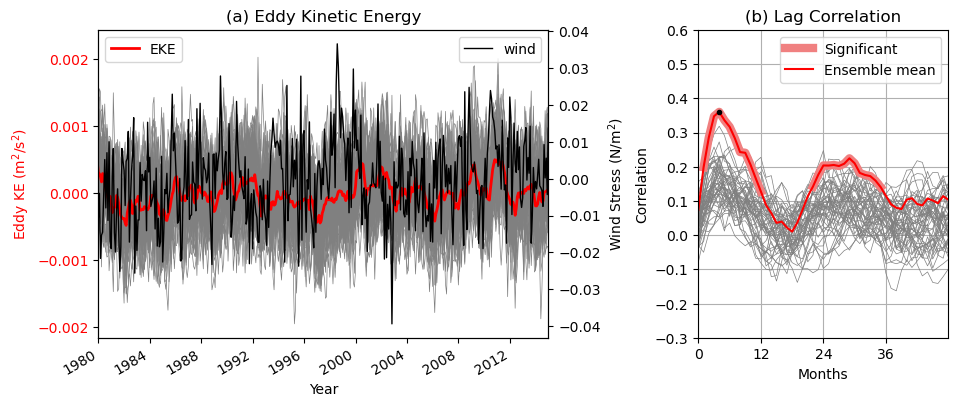

In [34]:
plt.figure(figsize=(10, 4))

## Axes to plot EKE timeseries
ax_eke = plt.axes([0.1,0.13,0.45,0.77])
## Axes to plot lagged correlation
ax_corr = plt.axes([0.7,0.13,0.25,0.77])

tau_clim = tau.groupby('time.month').mean('time')
tau_deseas = (tau.groupby('time.month') - tau_clim)

for result in eke_results:
    eke_clim = result['eke'].groupby('time.month').mean('time')
    eke_deseas = (result['eke'].groupby('time.month') - eke_clim)
    eke_deseas.plot(ax=ax_eke,color=[0.5, 0.5, 0.5],linewidth=0.5)
    
    coef, signif, Neff, Neff2 = pearsoncor(tau_deseas,eke_deseas)
    ax_corr.plot(coef,color=[0.5, 0.5, 0.5],linewidth=0.5)

# In this case I am filtering eke_sum -- rather than averaging and then filtering
eke_sum_clim = eke_sum.groupby('time.month').mean('time')
eke_sum_deseas = (eke_sum.groupby('time.month') - eke_sum_clim)
eke_sum_deseas.plot(ax=ax_eke,color=col,linewidth=2,label='EKE')
ax_eke.set_xlabel('Year')
ax_eke.set_ylabel('Eddy KE (m$^2$/s$^2$)',color=col)
#ax_eke.set_yticks([0.01, .011, .012])
ax_eke.tick_params('y',labelcolor=col)
ax_eke.set_xlim([start,end])
ax_eke.set_title('(a) Eddy Kinetic Energy')
ax_eke.legend()

## Axes to plot the wind
ax_tau=ax_eke.twinx()

tau_deseas.plot(ax=ax_tau,color='k',linewidth=1,label='wind')
#ax_tau.set_ylim([0.135,0.185])
ax_tau.set_ylabel('Wind Stress (N/m$^2$)')
ax_tau.set_xlim([start,end])

ax_tau.legend()

coef_sum, signif_sum, Neff_sum, Neff_sum2 = pearsoncor(tau_deseas,eke_sum_deseas)
lag = coef_sum.argmax() 
print('Correlations: %d months, %0.2f, %0.2f'%(lag, coef_sum[lag], signif_sum[lag]))
print('Effective sample size: %d or %d'%(Neff[lag], Neff2))
T = coef_sum[lag]*Neff_sum[lag]**(0.5)*(1-coef_sum[lag]**2)**(-0.5)
print('T-statistic at max correlation: %0.2f '% T)
Tstat = coef_sum*Neff_sum**(0.5)*(1-coef_sum**2)**(-0.5)
coef_sig = np.where(Tstat>1.96,coef_sum,np.NaN)
ax_corr.plot(coef_sig,linewidth=6,color='lightcoral',label='Significant')
ax_corr.plot(coef_sum,linewidth=1.5,color='r',label='Ensemble mean')
ax_corr.plot(lag,coef_sum[lag],'k.')

ax_corr.set_xlim([0,48])
ax_corr.set_ylim([-0.3,0.6])
ax_corr.set_xticks([0, 12, 24, 36])
ax_corr.set_title('(b) Lag Correlation')
ax_corr.set_xlabel('Months')
ax_corr.set_ylabel('Correlation')
ax_corr.grid()
ax_corr.legend()


# Option 3a

This is probably the best option. It uses the deseasonalised records from option 3, with Kial's effective sample size, but runs a 4-month filter through EKE and tau timeseries before plotting (but not for correlations).

Southern Ocean -- fraction of intrinsic variance: R_i = 0.82
Correlations: 4 months, 0.36, 0.00
Effective sample size: 231 or 33
T-statistic at max correlation: 5.88 
T-statistic at max correlation for Member 5: 5.45  -- lag: 4
T-statistic at max correlation for Member 25: 4.19  -- lag: 24
T-statistic  for Member 25: 2.43  -- lag: 6


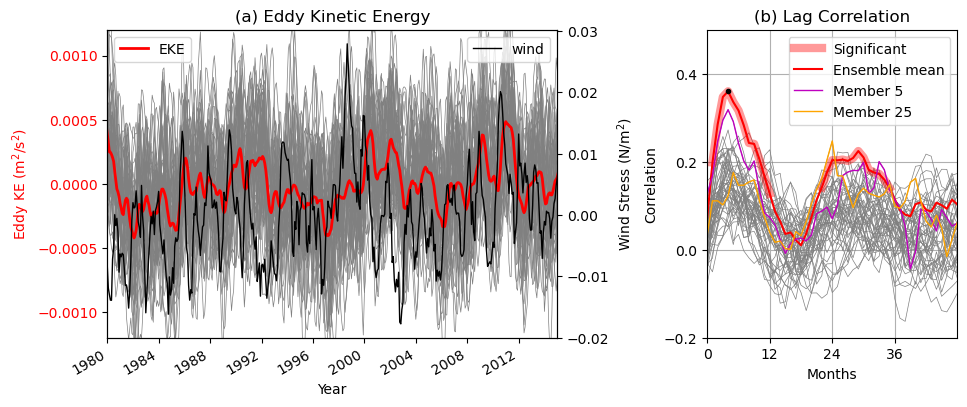

In [13]:
plt.figure(figsize=(10, 4))

## Axes to plot EKE timeseries
ax_eke = plt.axes([0.1,0.13,0.45,0.77])
## Axes to plot lagged correlation
ax_corr = plt.axes([0.7,0.13,0.25,0.77])

tau_clim = tau.groupby('time.month').mean('time')
tau_deseas = (tau.groupby('time.month') - tau_clim)

# In this case I am filtering eke_sum -- rather than averaging and then filtering
eke_sum_clim = eke_sum.groupby('time.month').mean('time')
eke_sum_deseas = (eke_sum.groupby('time.month') - eke_sum_clim)

for result in eke_results:
    ii = result['ii']
    eke_clim = result['eke'].groupby('time.month').mean('time')
    eke_deseas = (result['eke'].groupby('time.month') - eke_clim)
    if ii==1:
        eke_var = (eke_deseas - eke_sum_deseas)**2
    else:
        eke_var = eke_var + (eke_deseas - eke_sum_deseas)**2
        
    eke_deseas.rolling(time=4,center=True).mean().plot(ax=ax_eke,color=[0.5, 0.5, 0.5],linewidth=0.5)
    
    coef, signif, Neff, Neff2 = pearsoncor(tau_deseas,eke_deseas)
    ax_corr.plot(coef,color=[0.5, 0.5, 0.5],linewidth=0.5)

eke_var = eke_var/nn
sigma2 = np.var(eke_sum_deseas)  
epsilon2 = eke_var.mean('time')
ratio = (epsilon2/(epsilon2+sigma2))
print('Southern Ocean -- fraction of intrinsic variance: R_i = %0.2f'%ratio.values)
    
eke_sum_deseas.rolling(time=4,center=True).mean().plot(ax=ax_eke,color=col,linewidth=2,label='EKE')
ax_eke.set_xlabel('Year')
ax_eke.set_ylabel('Eddy KE (m$^2$/s$^2$)',color=col)
ax_eke.set_ylim([-0.0012, .0012])
ax_eke.tick_params('y',labelcolor=col)
ax_eke.set_xlim([start,end])
ax_eke.set_title('(a) Eddy Kinetic Energy')
ax_eke.legend()

## Axes to plot the wind
ax_tau=ax_eke.twinx()

tau_deseas.rolling(time=4,center=True).mean().plot(ax=ax_tau,color='k',linewidth=1,label='wind')
#ax_tau.set_ylim([0.135,0.185])
ax_tau.set_ylabel('Wind Stress (N/m$^2$)')
ax_tau.set_xlim([start,end])

ax_tau.legend()

coef_sum, signif_sum, Neff_sum, Neff_sum2 = pearsoncor(tau_deseas,eke_sum_deseas)
lag = coef_sum.argmax() 
print('Correlations: %d months, %0.2f, %0.2f'%(lag, coef_sum[lag], signif_sum[lag]))
print('Effective sample size: %d or %d'%(Neff_sum[lag], Neff_sum2))
T = coef_sum[lag]*Neff_sum[lag]**(0.5)*(1-coef_sum[lag]**2)**(-0.5)
print('T-statistic at max correlation: %0.2f '% T)
Tstat = coef_sum*Neff_sum**(0.5)*(1-coef_sum**2)**(-0.5)
coef_sig = np.where(Tstat>1.96,coef_sum,np.NaN)
ax_corr.plot(coef_sig,linewidth=6,color='r',alpha=0.4,label='Significant')
ax_corr.plot(coef_sum,linewidth=1.5,color='r',label='Ensemble mean')
ax_corr.plot(lag,coef_sum[lag],'k.')

ax_corr.set_xlim([0,48])
ax_corr.set_ylim([-0.2,0.5])
ax_corr.set_xticks([0, 12, 24, 36])
ax_corr.set_yticks([-0.2, 0.0, 0.2, 0.4])
ax_corr.set_title('(b) Lag Correlation')
ax_corr.set_xlabel('Months')
ax_corr.set_ylabel('Correlation')
ax_corr.grid()


# extra line!!
result = eke_results[5]
eke_clim = result['eke'].groupby('time.month').mean('time')
eke_deseas = (result['eke'].groupby('time.month') - eke_clim)
coef, signif, Neff, Neff2 = pearsoncor(tau_deseas,eke_deseas)
ax_corr.plot(coef,color='m',linewidth=1,label='Member 5')
lag = coef.argmax() 
T = coef[lag]*Neff[lag]**(0.5)*(1-coef[lag]**2)**(-0.5)
print('T-statistic at max correlation for Member 5: %0.2f  -- lag: %d'% (T,lag))

# extra line!!
result = eke_results[25]
eke_clim = result['eke'].groupby('time.month').mean('time')
eke_deseas = (result['eke'].groupby('time.month') - eke_clim)
coef, signif, Neff, Neff2 = pearsoncor(tau_deseas,eke_deseas)
ax_corr.plot(coef,color='orange',linewidth=1,label='Member 25')
lag = coef.argmax() 
T = coef[lag]*Neff[lag]**(0.5)*(1-coef[lag]**2)**(-0.5)
print('T-statistic at max correlation for Member 25: %0.2f  -- lag: %d'% (T,lag))
T = coef[6]*Neff[6]**(0.5)*(1-coef[6]**2)**(-0.5)
print('T-statistic  for Member 25: %0.2f  -- lag: %d'% (T,6))

ax_corr.legend()

plt.savefig('../paper/figures/Figure2.png',dpi=200)